# Validation SIMCOSTA Data - NOAA Guide

- ~Load SIMCOSTA data~
- Code for tests using NOAA guide (in remo aplication folder)
- Write global code in which an 
- Compare with QC data for "validation of validation"
- 

In [1]:
# importando bibliotecas
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import os
from glob import glob

## Loading data

In [2]:
# General folder
data_folder_path = 'C:\\Users\\Thiago\\Desktop\\Temporary HD Files\\mestrado_recuperado\\Aplicações Empregos\\Bolsa_REMO_observacional\\dados'

# RIO SIMCOSTA BUOY
# loading data
os.chdir(data_folder_path) # chdir
list_of_files = glob('*.csv') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)
buoy = pd.read_csv('SIMCOSTA_RJ-4_OCEAN_2017-08-28_2022-03-17.csv',skiprows=35) # load

# creating datetime index
datetime_cols = ['YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE', 'SECOND']
buoy['datetime'] = pd.to_datetime(buoy[datetime_cols])
buoy.drop(columns=datetime_cols,inplace=True)
buoy.set_index('datetime',inplace=True)

# creating julian days col
jd_2017 = pd.to_datetime('2017-01-01T00:00').to_julian_date()
jd_data_start = pd.to_datetime(buoy.index[0]).to_julian_date()
buoy['jd_2017'] = buoy.index.to_julian_date() - jd_2017 # julian days from 2017-01-01T00:00
buoy['jd_dstart'] = buoy.index.to_julian_date() - jd_data_start # julian days starting at time 0 of the data

# selecting relevant data
buoy = buoy[['Hsig','TP','Tsig', 'Avg_Wv_Dir','jd_2017', 'jd_dstart']]
buoy = buoy.rename(columns={'Hsig':'Hs','TP':'Tp','Tsig':'Ts','Avg_Wv_Dir':'Dm'})

# # pre-processing data
# buoy['Tp'] = buoy['Tp'].where(buoy['Tp']<30)


In [3]:
def spike_test(data_original, param, threshold=(None,None)):
    
    data = data_original.copy()
    threshold_low = threshold[0]
    threshold_high = threshold[1]
    
    my_func = lambda x: ((x[0] + x[2]) / 2)  
    data[f'{param}_spike_test_spk_ref'] = data[param].rolling(3,center=True).apply(my_func)
    
    data[f'{param}_spike_test_diff'] = np.abs(data[param]-data[f'{param}_spike_test_spk_ref'])
    
    cond1 = data[f'{param}_spike_test_diff'] < threshold_low
    cond2 = data[f'{param}_spike_test_spk_ref'].isna()
    cond3 = (data[f'{param}_spike_test_diff'] >= threshold_low) & (data[f'{param}_spike_test_diff'] < threshold_high)
    cond4 = data[f'{param}_spike_test_diff'] > threshold_high
    
    data.loc[cond1,'flag_spk_test'] = 1
    data.loc[cond2,'flag_spk_test'] = 2
    data.loc[cond3,'flag_spk_test'] = 3
    data.loc[cond4,'flag_spk_test'] = 4
    data['flag_spk_test'] = data['flag_spk_test'].astype('Int64')
    
    return data


In [11]:
threshold = (0.7,0.9)
buoy_spike = spike_test(buoy, 'Hs', threshold=threshold)

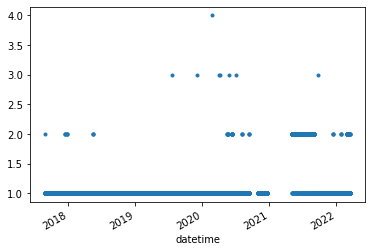

In [7]:
buoy_spike['flag_spk_test'].astype(int).plot(marker='.',ls='None');

In [8]:
def gross_range_test(data_original, param, sensor_output_range=(None,None),user_output_range=(None,None)):
    
    data = data_original.copy()
    sensor_output_range_low = sensor_output_range[0]
    sensor_output_range_high = sensor_output_range[1]
    user_output_range_low = user_output_range[0]
    user_output_range_high = user_output_range[1]
    
    cond1 = (data[param] > sensor_output_range_low) & (data[f'{param}'] < sensor_output_range_high) 
    cond3 = (data[param] < user_output_range_low) | (data[f'{param}'] > user_output_range_high) 
    cond4 = (data[param] < sensor_output_range_low) | (data[f'{param}'] > sensor_output_range_high) 
    
    data.loc[cond1,'flag_gross_test'] = 1
    data.loc[cond3,'flag_gross_test'] = 3
    data.loc[cond4,'flag_gross_test'] = 4
    data['flag_gross_test'] = data['flag_gross_test'].astype('Int64')
    
    return data

In [9]:
sensor_output_range = (-20,20)
user_output_range = (0,10)
buoy_gross = gross_range_test(buoy, 'Hs', sensor_output_range=sensor_output_range,user_output_range=user_output_range)

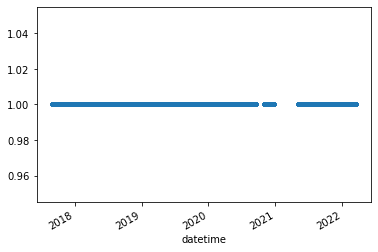

In [10]:
buoy_gross['flag_gross_test'].plot(marker='.',ls='None');

In [11]:
def rate_of_change_test(data_original, param, number_stds=3):
    
    data = data_original.copy()
    
    data[f'{param}_roc_test_nstd_25h'] = data[param].rolling('25h').std() * number_stds
#     time_delta = pd.Timedelta('25h')
#     start = data.index[0]
#     data.loc[start:start+time_delta] = np.NaN
    
    data[f'{param}_roc_test_diff'] = np.abs(data[param].diff(-1))

    cond1 = data[f'{param}_roc_test_diff'] < data[f'{param}_roc_test_nstd_25h']
    cond2 = (data[f'{param}_roc_test_diff'].isna()) | (data[f'{param}_roc_test_nstd_25h'].isna())
    cond3 = data[f'{param}_roc_test_diff'] > data[f'{param}_roc_test_nstd_25h']

    data.loc[cond1,'flag_roc_test'] = 1
    data.loc[cond2,'flag_roc_test'] = 2
    data.loc[cond3,'flag_roc_test'] = 3
    data['flag_roc_test'] = data['flag_roc_test'].astype('Int64')
    
    return data

In [12]:
buoy_roc = rate_of_change_test(buoy, 'Hs', number_stds=3)

<AxesSubplot:xlabel='datetime'>

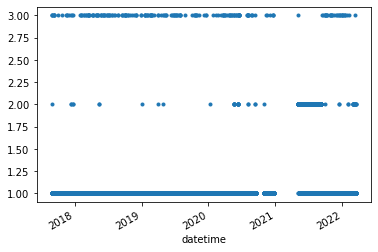

In [14]:
buoy_roc['flag_roc_test'].plot(marker='.',ls='none');

In [46]:
(0.9 - 0.9) < 0.1

True

In [7]:
#https://stackoverflow.com/questions/67853520/how-to-apply-rolling-t-test-with-pandas

In [8]:
def rolling5_function(x,eps=0.001):
    count = 0
    for i in range(len(x)):
        diff = x[i] - x[i-1]
        if diff < eps:
            count += 1
    if count >= 4:
        flag = 4
    else:
        flag = 1
    return flag         

In [9]:
buoy_cut = buoy['Hs'].iloc[0:50]
buoy_cut.iloc[6:10] = 0.9

In [10]:
flat_test = buoy_cut.rolling(5).apply(lambda x: rolling5_function(x,eps=0.001)).shift(periods=-3)
buoy_test = pd.concat([buoy['Hs'],flat_test],axis=1)

In [11]:
buoy_test.head(40)

,Hs,Hs
datetime,,
2017-08-28 13:25:00,0.94,NaN
2017-08-28 13:55:00,0.96,1.0
2017-08-28 14:55:00,0.89,1.0
2017-08-28 15:25:00,0.90,1.0
2017-08-28 15:55:00,0.91,1.0
2017-08-28 16:25:00,0.99,1.0
2017-08-28 16:55:00,0.90,4.0
2017-08-28 17:25:00,0.90,4.0
2017-08-28 17:55:00,0.90,1.0


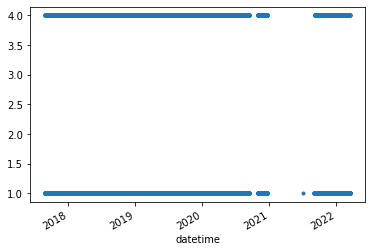

In [88]:
buoy_test.iloc[:,1].plot(marker='.',ls='None');

In [ ]:
def flat_test_function(data,eps=0.001):
    for i in range(len(data))
        rol_block = data.iloc[i:i+5].values
        count = 0
        for i in range(len(rol_block)):
            diff = rol_block[i] - rol_block[i-1]
            if diff < eps:
                count += 1
        if count >= 4:
            flag = 4
        else:
            flag = 1
    return flag  

In [20]:
buoy_cut['Hs']

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
EPS = 0.001 meter

def flat_line_test(data_original, param, rep_cnt_fail=5,rep_cnt_suspect=3,eps=0.001):
    
    data = data_original.copy()
    
    
    
    
    
    
    data[f'{param}_roc_test_nstd_25h'] = data[param].rolling('25h').std() * number_stds
#     time_delta = pd.Timedelta('25h')
#     start = data.index[0]
#     data.loc[start:start+time_delta] = np.NaN
    
    data[f'{param}_roc_test_diff'] = np.abs(data[param].diff(-1))

    cond1 = data[f'{param}_roc_test_diff'] < data[f'{param}_roc_test_nstd_25h']
    cond2 = (data[f'{param}_roc_test_diff'].isna()) | (data[f'{param}_roc_test_nstd_25h'].isna())
    cond3 = data[f'{param}_roc_test_diff'] > data[f'{param}_roc_test_nstd_25h']

    data.loc[cond1,'flag_roc_test'] = 1
    data.loc[cond2,'flag_roc_test'] = 2
    data.loc[cond3,'flag_roc_test'] = 3
    data['flag_roc_test'] = data['flag_roc_test'].astype('Int64')
    
    return data

## Overall function

In [178]:
hs = buoy['Hs']
flag_spk = buoy_spike.filter(regex='flag')
flag_gross = buoy_gross.filter(regex='flag')
flag_roc = buoy_roc.filter(regex='flag')
index = buoy.index

hs_QC = pd.concat([hs,flag_spk,flag_gross,flag_roc],axis=1)

In [ ]:
def QC_function(data,param,
               threshold_spk_test=(None,None),
               sensor_output_range_gross_test=(None,None),user_output_range=(None,None),)